In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread, imsave, imshow
from csbdeep.utils import plot_some, axes_dict, plot_history
from csbdeep.data import RawData, create_patches, anisotropic_distortions
from csbdeep.io import load_training_data, save_training_data
from csbdeep.models import Config, CARE


Bad key "text.kerning_factor" on line 4 in
C:\Users\aryan\anaconda3\envs\csb_bio\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


input  image size = (340, 384)
output image size = (340, 384)


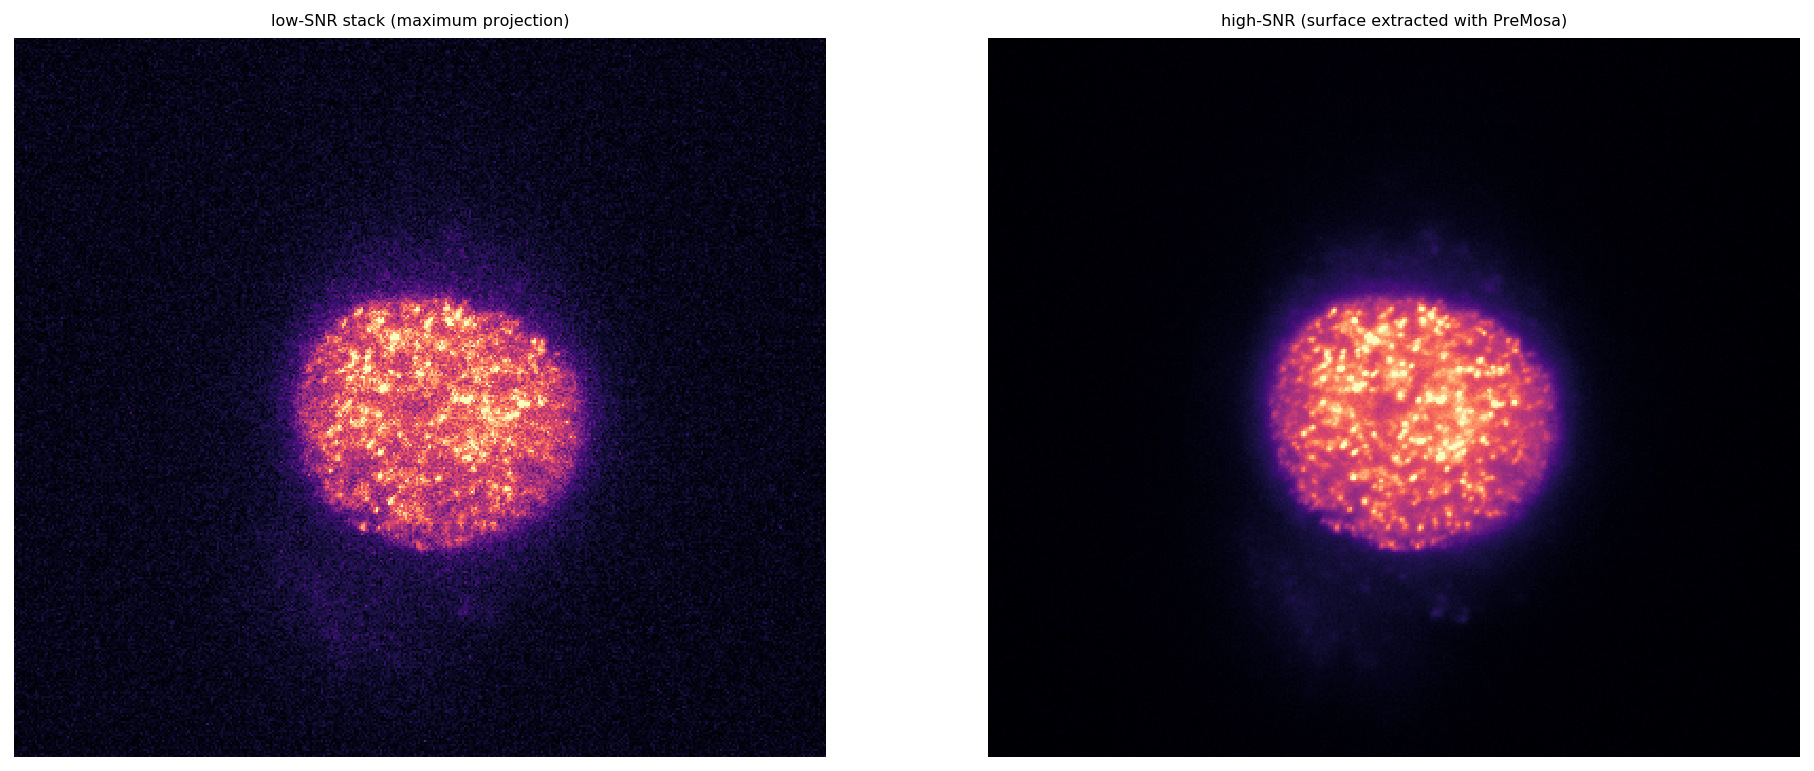

In [2]:
y = imread('data/nucleo/gt/001.tif')
x = imread('data/nucleo/in/001.tif')
print('input  image size =', x.shape)
print('output image size =', y.shape)

plt.figure(figsize=(16,10))
plot_some(np.stack([x,np.broadcast_to(y,x.shape)]),
    title_list=[['low-SNR stack (maximum projection)','high-SNR (surface extracted with PreMosa)']], 
    pmin=2,pmax=99.8);

In [3]:
raw_data = RawData.from_folder (
    basepath    = 'data/nucleo',
    source_dirs = ['in'],
    target_dir  = 'gt',
    axes        = 'CYX',
)

In [4]:
X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (256,256),
    n_patches_per_image = 1,
    save_file           = 'data/prevImg.npz'    
)

   41 raw images x    1 transformations   =    41 images
   41 images     x    1 patches per image =    41 patches in total
Input data:
data/nucleo: target='gt', sources=['in'], axes='CYX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
256 x 256


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 85.29it/s]


Saving data to data\prevImg.npz.


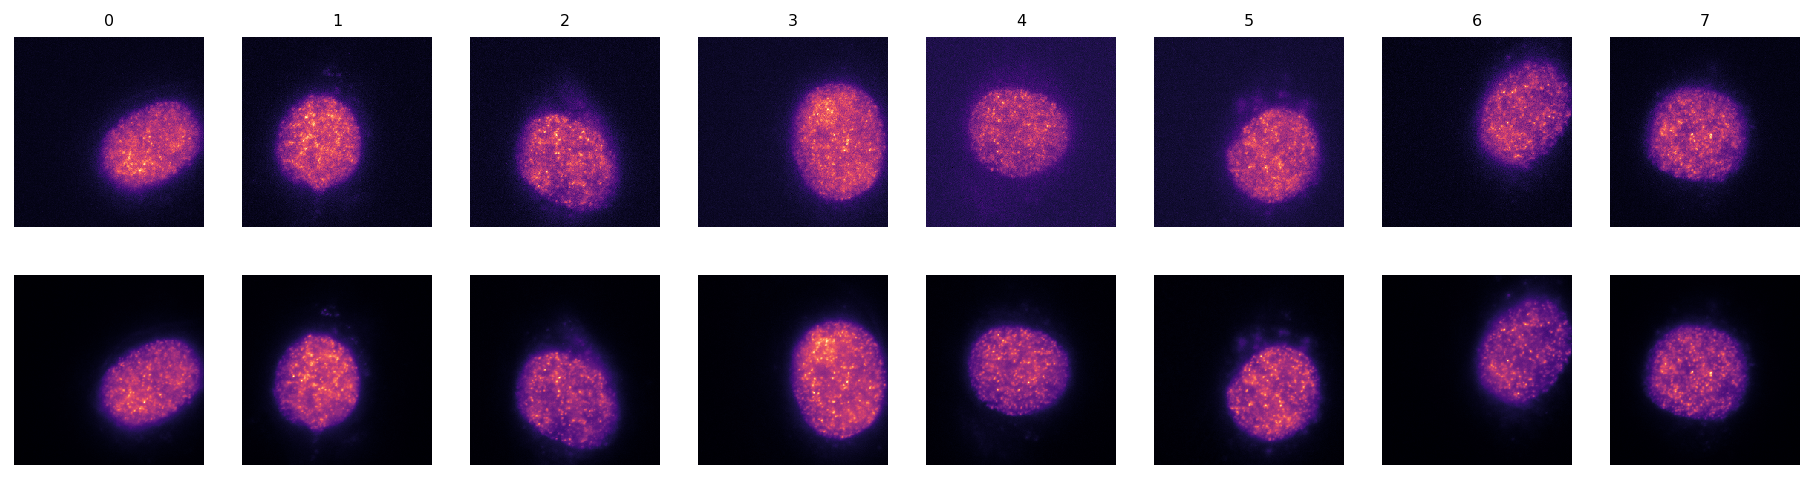

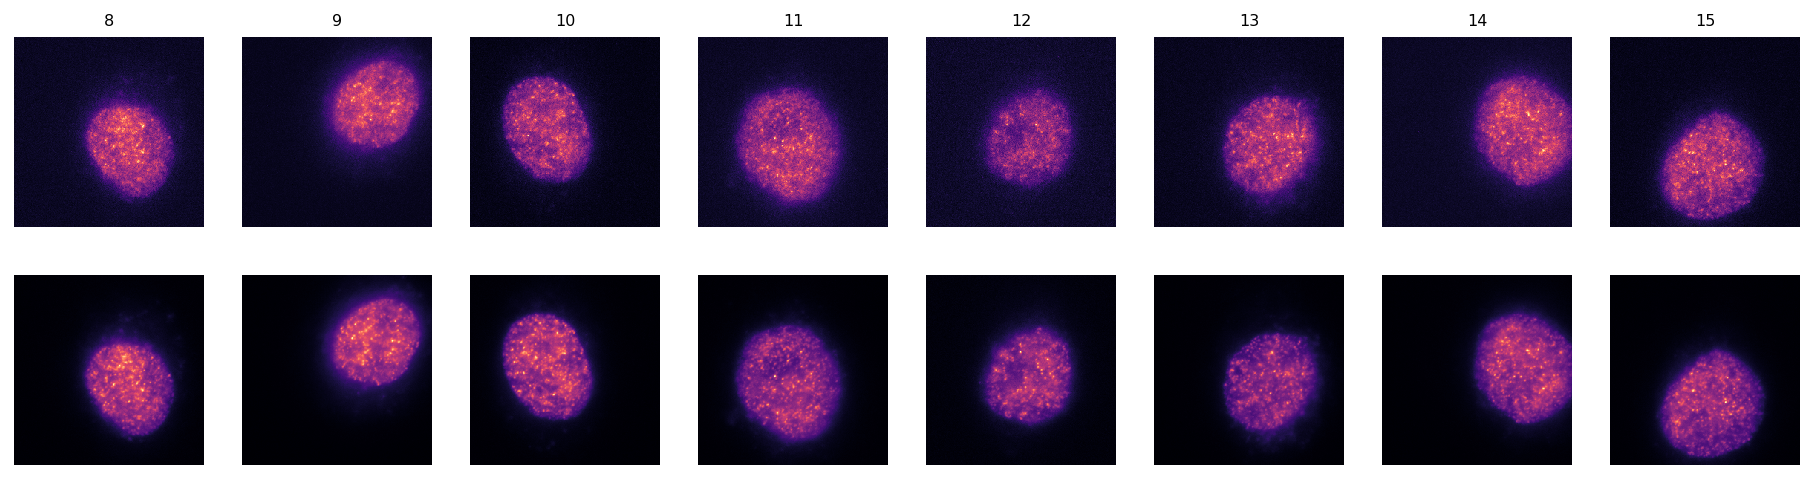

In [5]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;

In [6]:
prev = np.load('data/prevImg.npz')
synth = np.load('data/synthImg.npz')

newX = np.append(prev['X'], synth['X'], axis=0)
newY = np.append(prev['Y'], synth['Y'], axis=0)

In [7]:
save_training_data('data/mergedImg.npz', newX, newY, 'SCYX')

In [8]:
m = np.load('data/mergedImg.npz')
m['axes']

array('SCYX', dtype='<U4')

In [9]:
(X,Y), (X_val,Y_val), axes = load_training_data('data/mergedImg.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 50
number of validation images:	 6
image size (2D):		 (256, 256)
axes:				 SYXC
channels in / out:		 1 / 1


In [10]:
config = Config(axes, n_channel_in, n_channel_out, probabilistic=True, train_steps_per_epoch=400)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=True, train_batch_size=16, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='laplace', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=400, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': True,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 5,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'laplace',
 'train_epochs': 100,
 'train_steps_per_epoch': 400,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [11]:
model = CARE(config, 'network', basedir='models')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



C:\Users\aryan\anaconda3\envs\csb_bio\lib\site-packages\csbdeep\models\base_model.py:134: UserWarning: output path for model already exists, files may be overwritten: C:\Users\aryan\Desktop\CSBDeep\denoising-examples\denoising_bio\models\network
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


In [12]:
history = model.train(X,Y, validation_data=(X_val,Y_val))


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/100
400/400 [==============================] - 172s 431ms/step - loss: -1.1275 - mse: 0.0044 - mae: 0.0459 - val_loss: -1.7718 - val_mse: 0.0020 - val_mae: 0.0309

Epoch 2/100
400/400 [==============================] - 166s 414ms/step - loss: -1.8875 - mse: 0.0021 - mae: 0.0294 - val_loss: -1.2920 - val_mse: 0.0020 - val_mae: 0.0331
Epoch 3/100
400/400 [==============================] - 165s 413ms/step - loss: -2.2199 - mse: 0.0016 - mae: 0.0233 - val_loss: -1.8540 - val_mse: 0.0021 - val_mae: 0.0313
Epoch 4/100
400/400 [==============================] - 165s 413ms/step - loss: -2.4583 - mse: 0.0014 - mae: 0.0205 - v

400/400 [==============================] - 166s 414ms/step - loss: -3.3288 - mse: 1.9405e-04 - mae: 0.0083 - val_loss: -1.6213 - val_mse: 0.0023 - val_mae: 0.0312
Epoch 39/100
400/400 [==============================] - 166s 414ms/step - loss: -3.3221 - mse: 1.9434e-04 - mae: 0.0083 - val_loss: -1.6210 - val_mse: 0.0023 - val_mae: 0.0312
Epoch 40/100
400/400 [==============================] - 166s 414ms/step - loss: -3.3374 - mse: 1.9061e-04 - mae: 0.0082 - val_loss: -1.6177 - val_mse: 0.0023 - val_mae: 0.0312
Epoch 41/100
400/400 [==============================] - 166s 415ms/step - loss: -3.3255 - mse: 1.8993e-04 - mae: 0.0082 - val_loss: -1.6232 - val_mse: 0.0023 - val_mae: 0.0312

Epoch 00041: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 42/100
400/400 [==============================] - 166s 414ms/step - loss: -3.3508 - mse: 1.8725e-04 - mae: 0.0081 - val_loss: -1.5704 - val_mse: 0.0023 - val_mae: 0.0314
Epoch 43/100
400/400 [==============================

400/400 [==============================] - 165s 413ms/step - loss: -3.3726 - mse: 1.7749e-04 - mae: 0.0078 - val_loss: -1.4904 - val_mse: 0.0025 - val_mae: 0.0322
Epoch 83/100
400/400 [==============================] - 166s 415ms/step - loss: -3.3769 - mse: 1.7748e-04 - mae: 0.0078 - val_loss: -1.4913 - val_mse: 0.0025 - val_mae: 0.0322
Epoch 84/100
400/400 [==============================] - 165s 414ms/step - loss: -3.3759 - mse: 1.7745e-04 - mae: 0.0078 - val_loss: -1.4898 - val_mse: 0.0025 - val_mae: 0.0322
Epoch 85/100
400/400 [==============================] - 165s 413ms/step - loss: -3.3789 - mse: 1.7742e-04 - mae: 0.0078 - val_loss: -1.4890 - val_mse: 0.0025 - val_mae: 0.0322
Epoch 86/100
400/400 [==============================] - 165s 414ms/step - loss: -3.3864 - mse: 1.7740e-04 - mae: 0.0078 - val_loss: -1.4876 - val_mse: 0.0025 - val_mae: 0.0322
Epoch 87/100
400/400 [==============================] - 166s 414ms/step - loss: -3.3726 - mse: 1.7737e-04 - mae: 0.0078 - val_loss: -

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


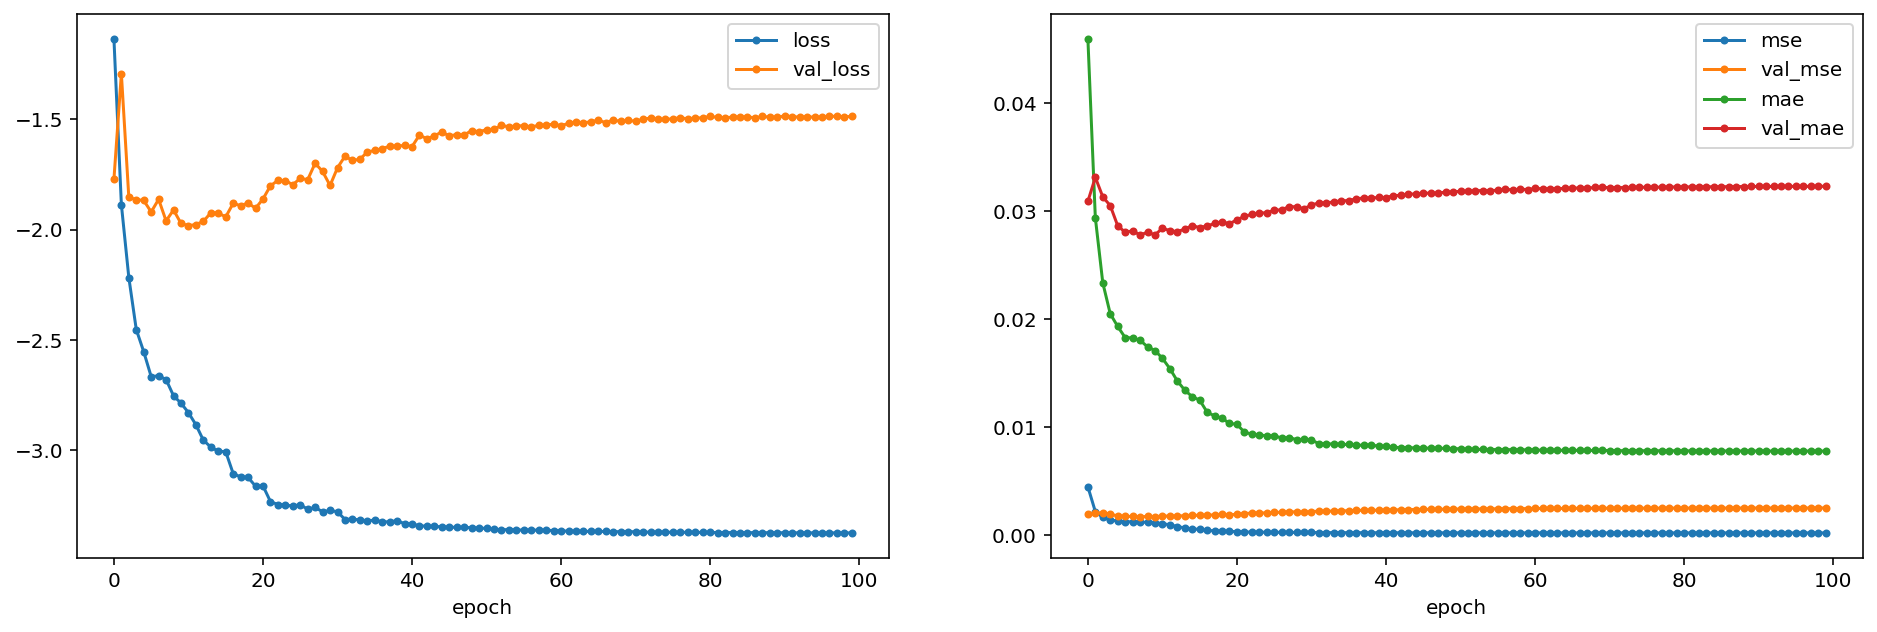

In [13]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

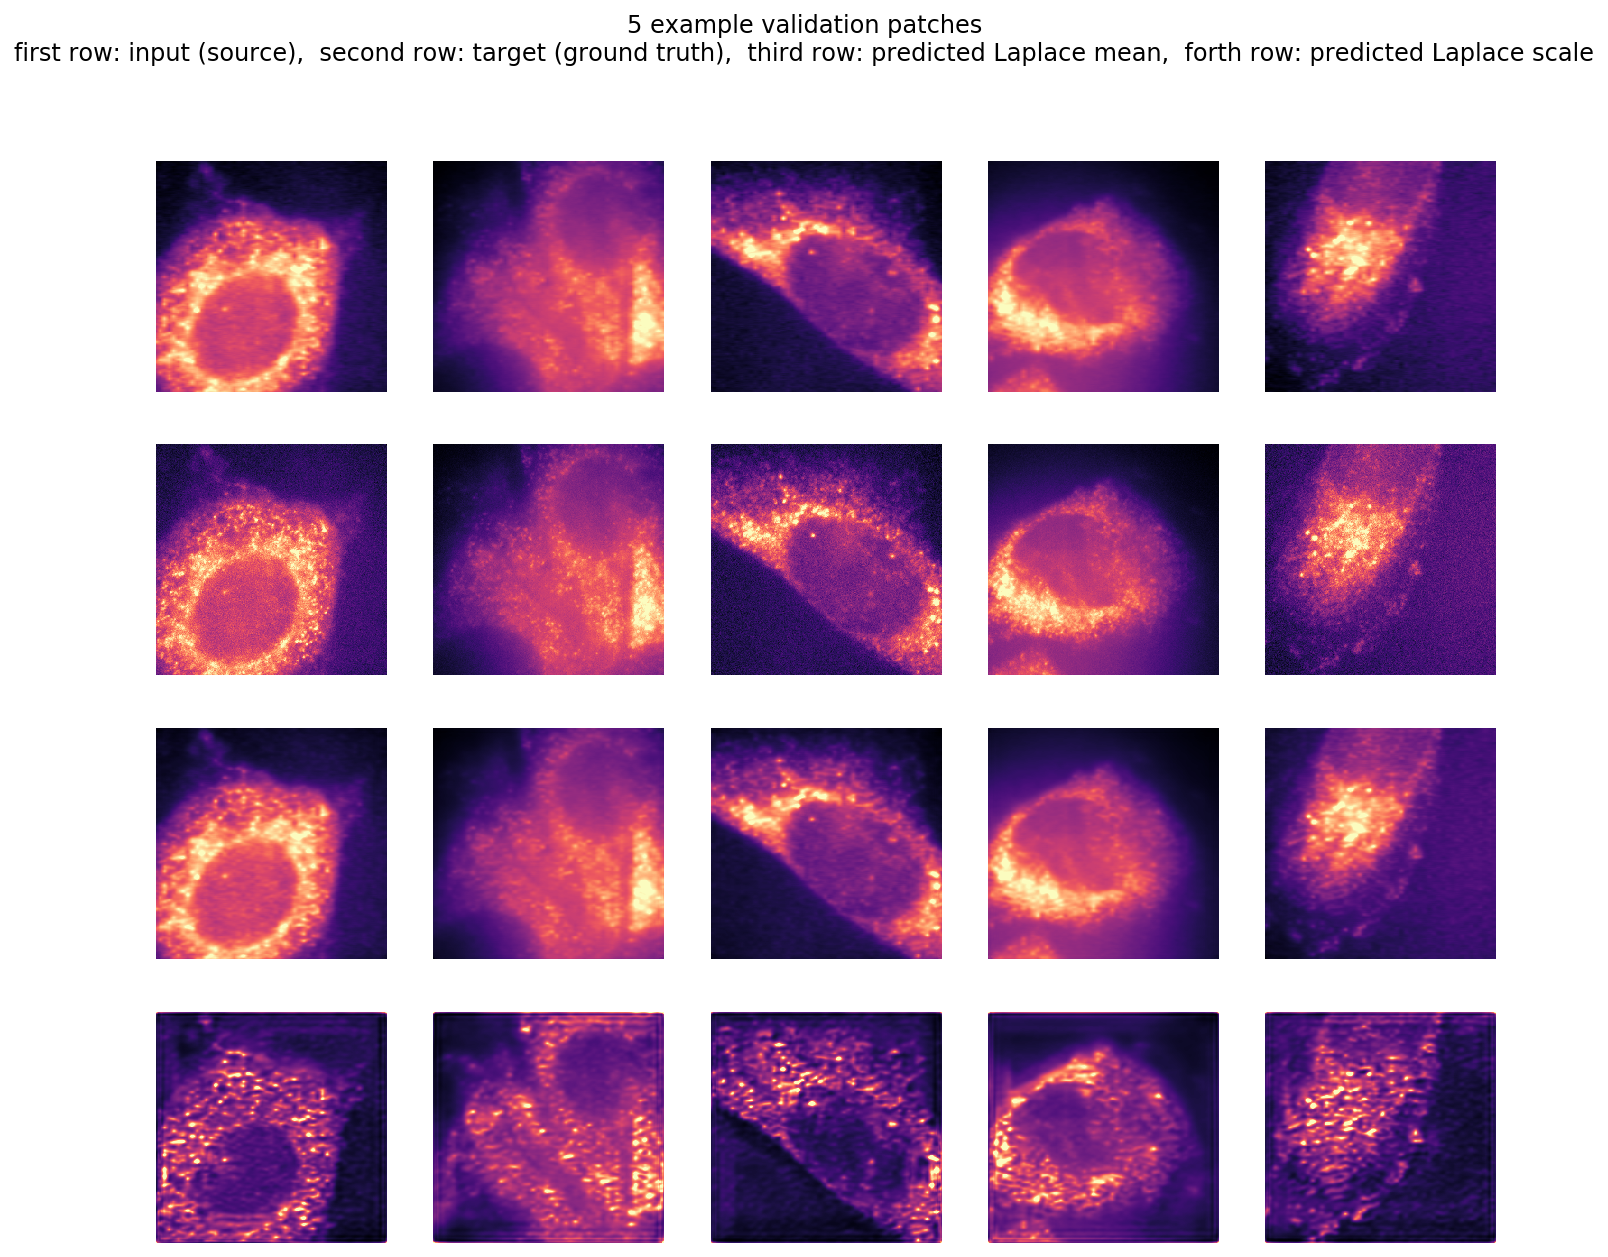

In [14]:
plt.figure(figsize=(12,10))
_P = model.keras_model.predict(X_val[:5])
_P_mean  = _P[...,:(_P.shape[-1]//2)]
_P_scale = _P[...,(_P.shape[-1]//2):]
plot_some(X_val[:5],Y_val[:5],_P_mean,_P_scale,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'first row: input (source),  '        
             'second row: target (ground truth),  '
             'third row: predicted Laplace mean,  '
             'forth row: predicted Laplace scale');